In [12]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [56]:
SEED = 666
DATA_FILE = '../Datasets/cats/data/breeds_data_final.pkl'
IMAGES_DIR = '../Datasets/cats/images'
RESOLUTION = 64
LEARNING_RATE = 0.01

In [26]:
# Cats data string convertor
# Data was collected from Analysis/cats/cats_prediction_2.ipynb
age_list = ['Adult', 'Baby', 'Senior', 'Young']
gender_list = ['Female', 'Male']
size_list = ['Extra Large', 'Large', 'Medium', 'Small']
coat_list = ['Hairless', 'Long', 'Medium', 'Short']
breed_list = ['Abyssinian', 'American Bobtail', 'American Curl',
        'American Shorthair', 'American Wirehair', 'Applehead Siamese',
        'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair',
        'Burmese', 'Burmilla', 'Calico', 'Canadian Hairless', 'Chartreux',
        'Chausie', 'Chinchilla', 'Cornish Rex', 'Cymric', 'Devon Rex',
        'Dilute Calico', 'Dilute Tortoiseshell', 'Domestic Long Hair',
        'Domestic Medium Hair', 'Domestic Short Hair', 'Egyptian Mau',
        'Exotic Shorthair', 'Extra-Toes Cat - Hemingway Polydactyl',
        'Havana', 'Himalayan', 'Japanese Bobtail', 'Javanese', 'Korat',
        'LaPerm', 'Maine Coon', 'Manx', 'Munchkin', 'Nebelung',
        'Norwegian Forest Cat', 'Ocicat', 'Oriental Long Hair',
        'Oriental Short Hair', 'Oriental Tabby', 'Persian', 'Pixiebob',
        'Ragamuffin', 'Ragdoll', 'Russian Blue', 'Scottish Fold',
        'Selkirk Rex', 'Siamese', 'Siberian', 'Silver', 'Singapura',
        'Snowshoe', 'Somali', 'Sphynx - Hairless Cat', 'Tabby', 'Tiger',
        'Tonkinese', 'Torbie', 'Tortoiseshell', 'Turkish Angora',
        'Turkish Van', 'Tuxedo', 'York Chocolate']

def get_cat_string(cat, value):
    if(cat == 'age'):
        return age_list[int(value)]
    elif(cat == 'gender'):
        return gender_list[int(value)]
    elif(cat == 'size'):
        return size_list[int(value)]
    elif(cat == 'coat'):
        return coat_list[int(value)]
    elif(cat == 'breed'):
        return breed_list[int(value)]

In [3]:
data = pd.read_pickle(DATA_FILE)
data

,age,gender,size,coat,breed,image
260,3.0,1.0,2.0,3.0,1.0,American Bobtail/46407834_34198.jpg
261,3.0,1.0,2.0,3.0,1.0,American Bobtail/46407781_34210.jpg
264,0.0,0.0,2.0,3.0,1.0,American Bobtail/46330160_41521.jpg
266,1.0,1.0,1.0,1.0,1.0,American Bobtail/46289156_45141.jpg
267,3.0,0.0,3.0,3.0,1.0,American Bobtail/46194971_53315.jpg
...,...,...,...,...,...,...
67139,1.0,0.0,2.0,3.0,65.0,Tuxedo/43784347_7292.jpg
67140,1.0,1.0,2.0,3.0,65.0,Tuxedo/43781057_7295.jpg
67141,0.0,0.0,2.0,3.0,65.0,Tuxedo/43773439_7304.jpg
67142,3.0,0.0,1.0,3.0,65.0,Tuxedo/43773383_7305.jpg


# Prepare Data

In [32]:
# Images
import cv2
import random

random.seed(SEED)

In [67]:
def load_images(df):
    images = []
    for path in df['image']:
        img = cv2.resize(cv2.imread(os.path.join(IMAGES_DIR, path), cv2.COLOR_BGR2RGB), (RESOLUTION, RESOLUTION), interpolation=cv2.INTER_CUBIC)            # Read and resize
        if(img is None):
            raise Exception('Error reading path', path)
        images.append(img.astype(np.float32) / 255.0)        # Normalize data to range [0,1])
    return np.array(images)

In [68]:
images = load_images(data)

In [69]:
print(len(data.iloc[:, 4]))
print(images.shape)

37794
(37794, 64, 64, 3)


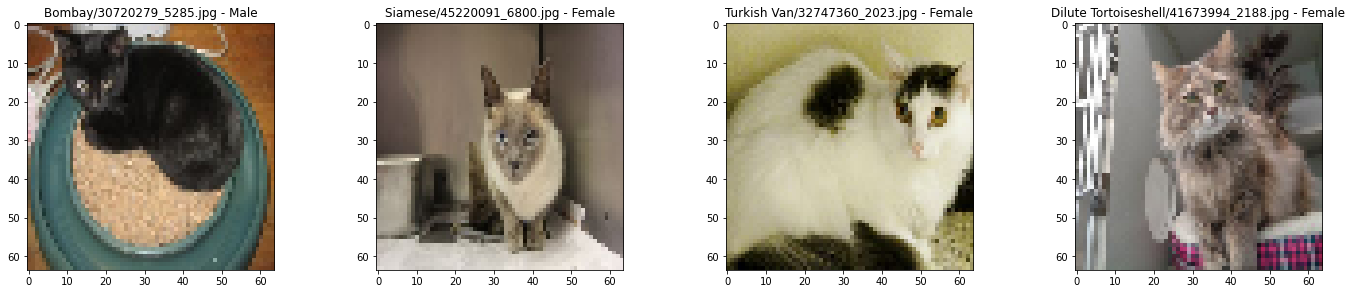

In [71]:
# I'm doubting if ML can determine a cat's gender... will test it using CNN
fig = plt.figure(figsize=(24, 10))
for i, r in enumerate([random.randint(0, 37794) for _ in range(4)]):
    ax = plt.subplot(2, 4, i + 1)
    ax.set_title(data.iloc[r, 5] + ' - ' + get_cat_string('gender', data.iloc[r, 1]))
    ax.imshow(cv2.cvtColor(images[r], cv2.COLOR_BGR2RGB))

# Network 1 - Basic CNN

In [86]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [73]:
# Breeds - [:, 4] are labels, images are X
train_X, val_X, train_y, val_y = train_test_split(images, data.iloc[:, 4], random_state = SEED, test_size=0.2)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(30235, 64, 64, 3) (30235,) (7559, 64, 64, 3) (7559,)


In [91]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(RESOLUTION, RESOLUTION, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(512, activation='relu'))
model_1.add(layers.Dense(66, activation='softmax'))

model_1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 4, 4, 128)        

In [92]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_1 = model_1.fit(train_X, to_categorical(train_y), epochs=10, validation_data=(val_X, to_categorical(val_y)))

Epoch 1/10
945/945 [==============================] - 20s 20ms/step - loss: 3.1902 - accuracy: 0.0850 - val_loss: 2.9012 - val_accuracy: 0.1491
Epoch 2/10
945/945 [==============================] - 19s 20ms/step - loss: 2.8848 - accuracy: 0.1513 - val_loss: 2.7851 - val_accuracy: 0.1830
Epoch 3/10
945/945 [==============================] - 91s 96ms/step - loss: 2.7812 - accuracy: 0.1860 - val_loss: 2.6984 - val_accuracy: 0.2092
Epoch 4/10
945/945 [==============================] - 26s 27ms/step - loss: 2.6926 - accuracy: 0.2020 - val_loss: 2.6640 - val_accuracy: 0.2086
Epoch 5/10
945/945 [==============================] - 23s 24ms/step - loss: 2.6225 - accuracy: 0.2293 - val_loss: 2.5970 - val_accuracy: 0.2356
Epoch 6/10
945/945 [==============================] - 21s 23ms/step - loss: 2.5477 - accuracy: 0.2447 - val_loss: 2.5578 - val_accuracy: 0.2459
Epoch 7/10
945/945 [==============================] - 25s 26ms/step - loss: 2.4811 - accuracy: 0.2625 - val_loss: 2.5308 - val_accuracy:

# Network 2 - Combine Net